In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from alpha_excel2.core.facade import AlphaExcel

## 1. AlphaExcel 초기화

In [2]:
ae = AlphaExcel(
    start_time='2016-01-28',
    end_time='2024-12-31',
    universe=None,
    config_path='../config'
)

print(f"기간: {ae._start_time} ~ {ae._end_time}")
print(f"유니버스 크기: {ae._universe_mask._data.shape}")

Config file not found: ..\config\preprocessing.yaml. Using empty config.


기간: 2016-01-28 00:00:00 ~ 2024-12-31 00:00:00
유니버스 크기: (2192, 2926)


## 2. 데이터 필드 로딩

In [3]:
f = ae.field
o = ae.ops

# 원본 데이터 필드 로딩
adj_close = f('fnguide_adj_close')
market_cap = f('fnguide_market_cap')
industry_group = f('fnguide_industry_group')

print("데이터 필드 로딩 완료.")

데이터 필드 로딩 완료.


## 3. 일간 수익률 계산

In [4]:
# 전일 종가 가져오기
prev_close = o.ts_delay(adj_close, window=1)

# 수익률 계산
returns = (adj_close - prev_close) / prev_close

print("[일간 수익률 통계]")
returns_df = returns.to_df()
print(f"평균 수익률: {returns_df.mean().mean():.6f}")
print(f"표준편차: {returns_df.std().mean():.6f}")

[일간 수익률 통계]
평균 수익률: -0.000168
표준편차: 0.033828


## 4. 동종업체 수익률 계산

In [5]:
# 동일가중 동종업체 수익률
ew_numerator = o.group_sum(returns, industry_group) - returns
ew_denominator = o.group_count(industry_group) - 1
ew_peer_return = ew_numerator / ew_denominator

# 시가총액가중 동종업체 수익률
vw_numerator = o.group_sum(market_cap * returns, industry_group) - market_cap * returns
vw_denominator = o.group_sum(market_cap, industry_group) - market_cap
vw_peer_return = vw_numerator / vw_denominator

print("[동종업체 수익률 통계]")
print(f"동일가중 평균: {ew_peer_return.to_df().mean().mean():.6f}")
print(f"시총가중 평균: {vw_peer_return.to_df().mean().mean():.6f}")

[동종업체 수익률 통계]
동일가중 평균: 0.000187
시총가중 평균: 0.000592
시총가중 평균: 0.000592


---
# 테스트 1: 동종업체 수익률을 시그널로 사용

**가설**: 동종업체 수익률이 높은 종목이 향후 수익률도 높다 (모멘텀 전이 효과)

**시그널**:
- 통제: `market_cap`
- 동일가중 시그널: `ew_peer_return`
- 시총가중 시그널: `vw_peer_return`

## 테스트 1.1: 통제 전략 (시가총액)

In [6]:
# 스케일러 설정
# ae.set_scaler('DollarNeutral')
ae.set_scaler('LongOnly')

# 통제 시그널: 시가총액
test1_control_signal = market_cap
test1_control_weights = ae.to_weights(test1_control_signal)
test1_control_returns = ae.to_portfolio_returns(test1_control_weights)
test1_control_pnl = test1_control_returns.to_df().sum(axis=1)
test1_control_cum = test1_control_pnl.cumsum()
test1_control_sharpe = test1_control_pnl.mean() / test1_control_pnl.std() * np.sqrt(252)

print("[테스트 1 - 통제 (시가총액)]")
print(f"샤프 비율: {test1_control_sharpe:.2f}")
print(f"총 수익률: {test1_control_cum.iloc[-1]:.4f}")

[테스트 1 - 통제 (시가총액)]
샤프 비율: 0.22
총 수익률: 0.3306


## 테스트 1.2: 동일가중 동종업체 수익률 시그널

In [7]:
# 시그널: 동일가중 동종업체 수익률
test1_ew_signal = ew_peer_return
test1_ew_weights = ae.to_weights(test1_ew_signal)
test1_ew_returns = ae.to_portfolio_returns(test1_ew_weights)
test1_ew_pnl = test1_ew_returns.to_df().sum(axis=1)
test1_ew_cum = test1_ew_pnl.cumsum()
test1_ew_sharpe = test1_ew_pnl.mean() / test1_ew_pnl.std() * np.sqrt(252)

print("[테스트 1 - 동일가중 동종업체 수익률]")
print(f"샤프 비율: {test1_ew_sharpe:.2f}")
print(f"총 수익률: {test1_ew_cum.iloc[-1]:.4f}")

[테스트 1 - 동일가중 동종업체 수익률]
샤프 비율: 1.49
총 수익률: 2.6105


## 테스트 1.3: 시총가중 동종업체 수익률 시그널

In [8]:
# 시그널: 시총가중 동종업체 수익률
test1_vw_signal = vw_peer_return
test1_vw_weights = ae.to_weights(test1_vw_signal)
test1_vw_returns = ae.to_portfolio_returns(test1_vw_weights)
test1_vw_pnl = test1_vw_returns.to_df().sum(axis=1)
test1_vw_cum = test1_vw_pnl.cumsum()
test1_vw_sharpe = test1_vw_pnl.mean() / test1_vw_pnl.std() * np.sqrt(252)

print("[테스트 1 - 시총가중 동종업체 수익률]")
print(f"샤프 비율: {test1_vw_sharpe:.2f}")
print(f"총 수익률: {test1_vw_cum.iloc[-1]:.4f}")

[테스트 1 - 시총가중 동종업체 수익률]
샤프 비율: 1.10
총 수익률: 1.8357


## 테스트 1.4: 결과 비교

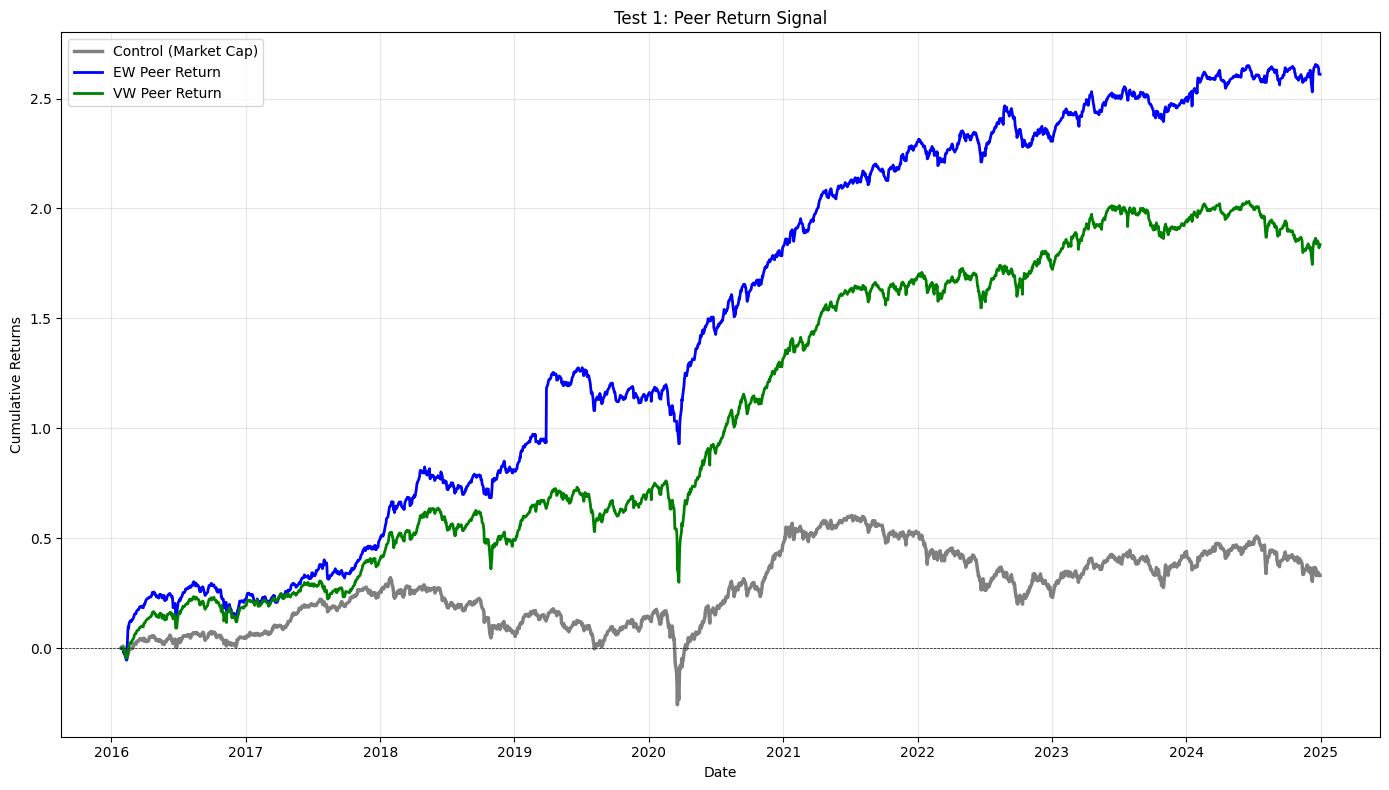


[테스트 1 결과]
전략                         샤프         총수익률       최대낙폭
-------------------- -------- ------------ ----------
통제 (시총)                  0.22       0.3306    -0.5781
동일가중 동종업체                1.49       2.6105    -0.3458
시총가중 동종업체                1.10       1.8357    -0.4618


In [9]:
# 그래프 비교
plt.figure(figsize=(14, 8))
plt.plot(test1_control_cum.index, test1_control_cum.values, label='Control (Market Cap)', linewidth=2.5, color='gray')
plt.plot(test1_ew_cum.index, test1_ew_cum.values, label='EW Peer Return', linewidth=2, color='blue')
plt.plot(test1_vw_cum.index, test1_vw_cum.values, label='VW Peer Return', linewidth=2, color='green')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Test 1: Peer Return Signal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 통계 출력
print("\n[테스트 1 결과]")
print(f"{'전략':<20} {'샤프':>8} {'총수익률':>12} {'최대낙폭':>10}")
print(f"{'-'*20} {'-'*8} {'-'*12} {'-'*10}")
print(f"{'통제 (시총)':<20} {test1_control_sharpe:>8.2f} {test1_control_cum.iloc[-1]:>12.4f} {(test1_control_cum - test1_control_cum.cummax()).min():>10.4f}")
print(f"{'동일가중 동종업체':<20} {test1_ew_sharpe:>8.2f} {test1_ew_cum.iloc[-1]:>12.4f} {(test1_ew_cum - test1_ew_cum.cummax()).min():>10.4f}")
print(f"{'시총가중 동종업체':<20} {test1_vw_sharpe:>8.2f} {test1_vw_cum.iloc[-1]:>12.4f} {(test1_vw_cum - test1_vw_cum.cummax()).min():>10.4f}")

---
# 테스트 2: 동종업체 대비 초과수익을 시그널로 사용

**가설**: 동종업체 대비 초과수익이 높은 종목이 계속 초과수익을 낸다 (상대 모멘텀)

**시그널**:
- 통제: `market_cap`
- 동일가중 시그널: `returns - ew_peer_return`
- 시총가중 시그널: `returns - vw_peer_return`

## 테스트 2.1: 통제 전략 (시가총액)

In [10]:
# 통제 시그널: 시가총액 (테스트 1과 동일)
test2_control_signal = market_cap
test2_control_weights = ae.to_weights(test2_control_signal)
test2_control_returns = ae.to_portfolio_returns(test2_control_weights)
test2_control_pnl = test2_control_returns.to_df().sum(axis=1)
test2_control_cum = test2_control_pnl.cumsum()
test2_control_sharpe = test2_control_pnl.mean() / test2_control_pnl.std() * np.sqrt(252)

print("[테스트 2 - 통제 (시가총액)]")
print(f"샤프 비율: {test2_control_sharpe:.2f}")
print(f"총 수익률: {test2_control_cum.iloc[-1]:.4f}")

[테스트 2 - 통제 (시가총액)]
샤프 비율: 0.22
총 수익률: 0.3306


## 테스트 2.2: 동일가중 초과수익 시그널

In [11]:
# 시그널: 자기 수익률 - 동일가중 동종업체 수익률
test2_ew_signal = returns - ew_peer_return
test2_ew_weights = ae.to_weights(test2_ew_signal)
test2_ew_returns = ae.to_portfolio_returns(test2_ew_weights)
test2_ew_pnl = test2_ew_returns.to_df().sum(axis=1)
test2_ew_cum = test2_ew_pnl.cumsum()
test2_ew_sharpe = test2_ew_pnl.mean() / test2_ew_pnl.std() * np.sqrt(252)

print("[테스트 2 - 동일가중 초과수익]")
print(f"샤프 비율: {test2_ew_sharpe:.2f}")
print(f"총 수익률: {test2_ew_cum.iloc[-1]:.4f}")

[테스트 2 - 동일가중 초과수익]
샤프 비율: 1.45
총 수익률: 2.7429


## 테스트 2.3: 시총가중 초과수익 시그널

In [12]:
# 시그널: 자기 수익률 - 시총가중 동종업체 수익률
test2_vw_signal = returns - vw_peer_return
test2_vw_weights = ae.to_weights(test2_vw_signal)
test2_vw_returns = ae.to_portfolio_returns(test2_vw_weights)
test2_vw_pnl = test2_vw_returns.to_df().sum(axis=1)
test2_vw_cum = test2_vw_pnl.cumsum()
test2_vw_sharpe = test2_vw_pnl.mean() / test2_vw_pnl.std() * np.sqrt(252)

print("[테스트 2 - 시총가중 초과수익]")
print(f"샤프 비율: {test2_vw_sharpe:.2f}")
print(f"총 수익률: {test2_vw_cum.iloc[-1]:.4f}")

[테스트 2 - 시총가중 초과수익]
샤프 비율: 1.26
총 수익률: 2.3396


## 테스트 2.4: 결과 비교

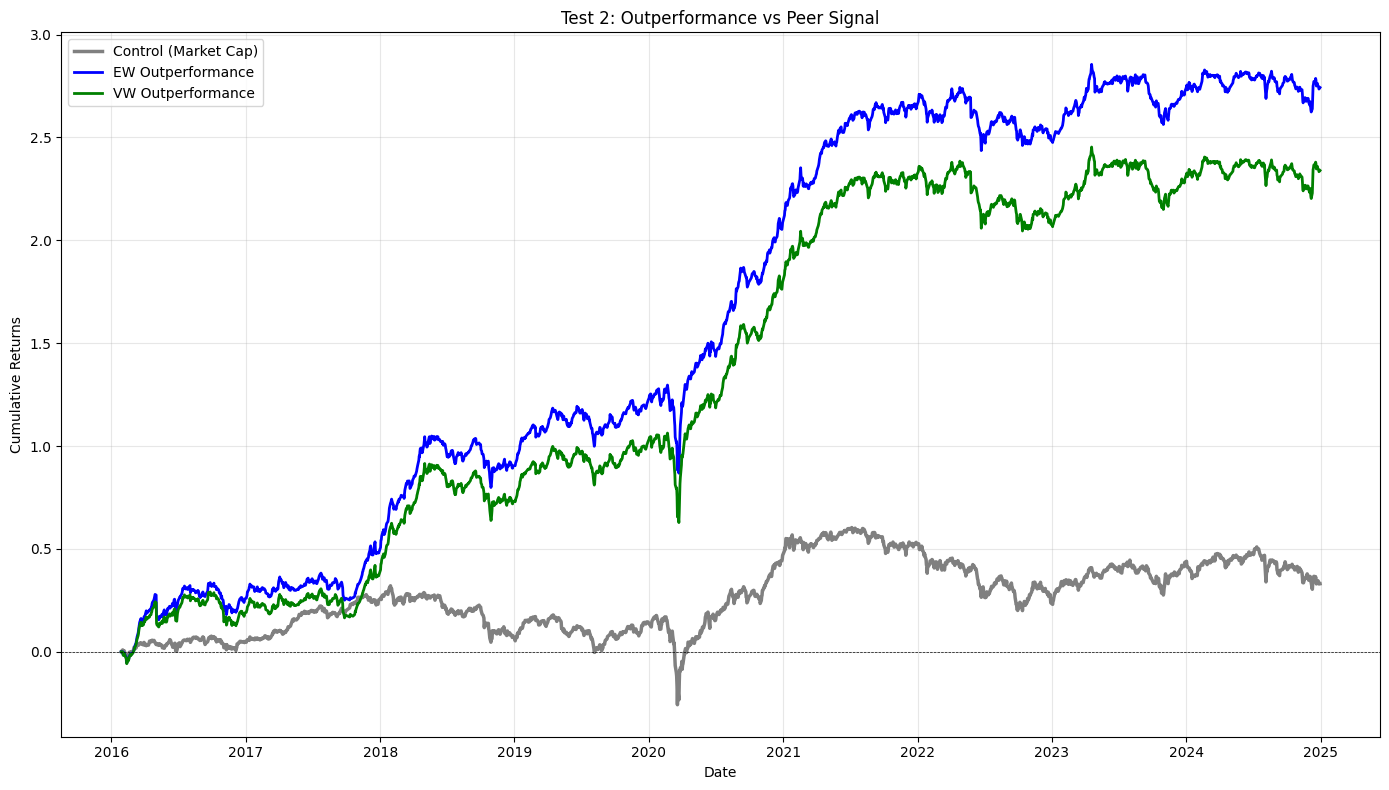


[테스트 2 결과]
전략                         샤프         총수익률       최대낙폭
-------------------- -------- ------------ ----------
통제 (시총)                  0.22       0.3306    -0.5781
동일가중 초과수익                1.45       2.7429    -0.4284
시총가중 초과수익                1.26       2.3396    -0.4351


In [13]:
# 그래프 비교
plt.figure(figsize=(14, 8))
plt.plot(test2_control_cum.index, test2_control_cum.values, label='Control (Market Cap)', linewidth=2.5, color='gray')
plt.plot(test2_ew_cum.index, test2_ew_cum.values, label='EW Outperformance', linewidth=2, color='blue')
plt.plot(test2_vw_cum.index, test2_vw_cum.values, label='VW Outperformance', linewidth=2, color='green')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Test 2: Outperformance vs Peer Signal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 통계 출력
print("\n[테스트 2 결과]")
print(f"{'전략':<20} {'샤프':>8} {'총수익률':>12} {'최대낙폭':>10}")
print(f"{'-'*20} {'-'*8} {'-'*12} {'-'*10}")
print(f"{'통제 (시총)':<20} {test2_control_sharpe:>8.2f} {test2_control_cum.iloc[-1]:>12.4f} {(test2_control_cum - test2_control_cum.cummax()).min():>10.4f}")
print(f"{'동일가중 초과수익':<20} {test2_ew_sharpe:>8.2f} {test2_ew_cum.iloc[-1]:>12.4f} {(test2_ew_cum - test2_ew_cum.cummax()).min():>10.4f}")
print(f"{'시총가중 초과수익':<20} {test2_vw_sharpe:>8.2f} {test2_vw_cum.iloc[-1]:>12.4f} {(test2_vw_cum - test2_vw_cum.cummax()).min():>10.4f}")

---
# 테스트 3: 그룹 중립화된 동종업체 수익률 시그널

**가설**: 업종 내 동종업체 수익률 차이 (업종 평균 제거 후)가 상대 성과를 예측

**시그널**:
- 통제: `group_neutralize(market_cap, industry_group)`
- 동일가중 시그널: `group_neutralize(ew_peer_return, industry_group)`
- 시총가중 시그널: `group_neutralize(vw_peer_return, industry_group)`

## 테스트 3.1: 통제 전략 (그룹 중립화 시가총액)

In [14]:
# 통제 시그널: 그룹 중립화된 시가총액
test3_control_signal = o.group_neutralize(market_cap, industry_group)
test3_control_weights = ae.to_weights(test3_control_signal)
test3_control_returns = ae.to_portfolio_returns(test3_control_weights)
test3_control_pnl = test3_control_returns.to_df().sum(axis=1)
test3_control_cum = test3_control_pnl.cumsum()
test3_control_sharpe = test3_control_pnl.mean() / test3_control_pnl.std() * np.sqrt(252)

print("[테스트 3 - 통제 (그룹 중립 시총)]")
print(f"샤프 비율: {test3_control_sharpe:.2f}")
print(f"총 수익률: {test3_control_cum.iloc[-1]:.4f}")

[테스트 3 - 통제 (그룹 중립 시총)]
샤프 비율: 0.25
총 수익률: 0.3949


## 테스트 3.2: 그룹 중립화 동일가중 동종업체 수익률 시그널

In [15]:
# 시그널: 그룹 중립화된 동일가중 동종업체 수익률
test3_ew_signal = o.group_neutralize(ew_peer_return, industry_group)
test3_ew_weights = ae.to_weights(test3_ew_signal)
test3_ew_returns = ae.to_portfolio_returns(test3_ew_weights)
test3_ew_pnl = test3_ew_returns.to_df().sum(axis=1)
test3_ew_cum = test3_ew_pnl.cumsum()
test3_ew_sharpe = test3_ew_pnl.mean() / test3_ew_pnl.std() * np.sqrt(252)

print("[테스트 3 - 그룹 중립 동일가중 동종업체]")
print(f"샤프 비율: {test3_ew_sharpe:.2f}")
print(f"총 수익률: {test3_ew_cum.iloc[-1]:.4f}")

[테스트 3 - 그룹 중립 동일가중 동종업체]
샤프 비율: -0.47
총 수익률: -1.0986


## 테스트 3.3: 그룹 중립화 시총가중 동종업체 수익률 시그널

In [16]:
# 시그널: 그룹 중립화된 시총가중 동종업체 수익률
test3_vw_signal = o.group_neutralize(vw_peer_return, industry_group)
test3_vw_weights = ae.to_weights(test3_vw_signal)
test3_vw_returns = ae.to_portfolio_returns(test3_vw_weights)
test3_vw_pnl = test3_vw_returns.to_df().sum(axis=1)
test3_vw_cum = test3_vw_pnl.cumsum()
test3_vw_sharpe = test3_vw_pnl.mean() / test3_vw_pnl.std() * np.sqrt(252)

print("[테스트 3 - 그룹 중립 시총가중 동종업체]")
print(f"샤프 비율: {test3_vw_sharpe:.2f}")
print(f"총 수익률: {test3_vw_cum.iloc[-1]:.4f}")

[테스트 3 - 그룹 중립 시총가중 동종업체]
샤프 비율: 0.15
총 수익률: 0.2648


## 테스트 3.4: 결과 비교

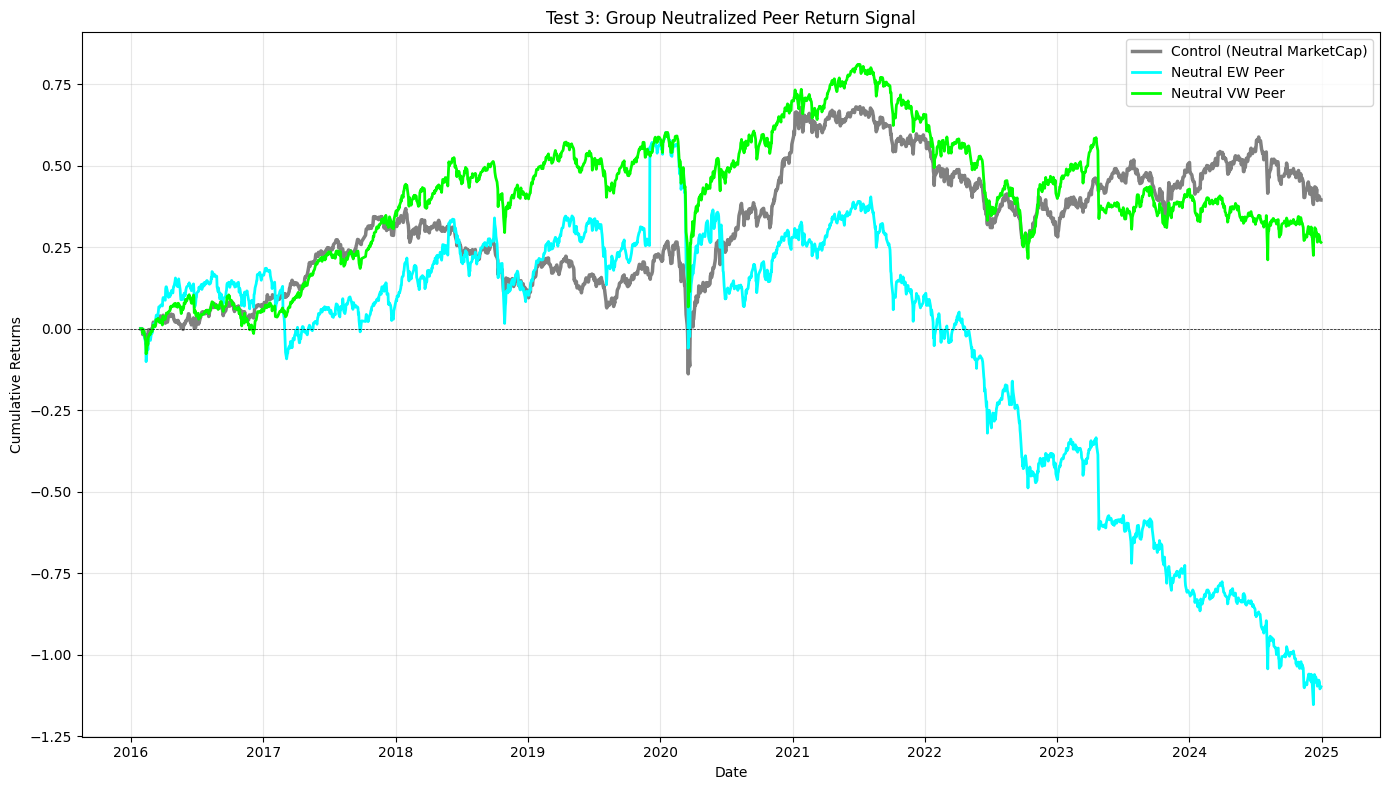


[테스트 3 결과]
전략                              샤프         총수익률       최대낙폭
------------------------- -------- ------------ ----------
통제 (중립 시총)                    0.25       0.3949    -0.5071
중립 동일가중 동종업체                 -0.47      -1.0986    -1.7563
중립 시총가중 동종업체                  0.15       0.2648    -0.5999


In [17]:
# 그래프 비교
plt.figure(figsize=(14, 8))
plt.plot(test3_control_cum.index, test3_control_cum.values, label='Control (Neutral MarketCap)', linewidth=2.5, color='gray')
plt.plot(test3_ew_cum.index, test3_ew_cum.values, label='Neutral EW Peer', linewidth=2, color='cyan')
plt.plot(test3_vw_cum.index, test3_vw_cum.values, label='Neutral VW Peer', linewidth=2, color='lime')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Test 3: Group Neutralized Peer Return Signal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 통계 출력
print("\n[테스트 3 결과]")
print(f"{'전략':<25} {'샤프':>8} {'총수익률':>12} {'최대낙폭':>10}")
print(f"{'-'*25} {'-'*8} {'-'*12} {'-'*10}")
print(f"{'통제 (중립 시총)':<25} {test3_control_sharpe:>8.2f} {test3_control_cum.iloc[-1]:>12.4f} {(test3_control_cum - test3_control_cum.cummax()).min():>10.4f}")
print(f"{'중립 동일가중 동종업체':<25} {test3_ew_sharpe:>8.2f} {test3_ew_cum.iloc[-1]:>12.4f} {(test3_ew_cum - test3_ew_cum.cummax()).min():>10.4f}")
print(f"{'중립 시총가중 동종업체':<25} {test3_vw_sharpe:>8.2f} {test3_vw_cum.iloc[-1]:>12.4f} {(test3_vw_cum - test3_vw_cum.cummax()).min():>10.4f}")

---
# 요약: 전체 테스트 비교

In [18]:
# 종합 비교 테이블 생성
summary = pd.DataFrame({
    '테스트': [
        '테스트 1', '테스트 1', '테스트 1',
        '테스트 2', '테스트 2', '테스트 2',
        '테스트 3', '테스트 3', '테스트 3'
    ],
    '전략': [
        '통제 (시총)', '동일가중 동종업체', '시총가중 동종업체',
        '통제 (시총)', '동일가중 초과수익', '시총가중 초과수익',
        '통제 (중립 시총)', '중립 동일가중', '중립 시총가중'
    ],
    '샤프': [
        test1_control_sharpe, test1_ew_sharpe, test1_vw_sharpe,
        test2_control_sharpe, test2_ew_sharpe, test2_vw_sharpe,
        test3_control_sharpe, test3_ew_sharpe, test3_vw_sharpe
    ],
    '총수익률': [
        test1_control_cum.iloc[-1], test1_ew_cum.iloc[-1], test1_vw_cum.iloc[-1],
        test2_control_cum.iloc[-1], test2_ew_cum.iloc[-1], test2_vw_cum.iloc[-1],
        test3_control_cum.iloc[-1], test3_ew_cum.iloc[-1], test3_vw_cum.iloc[-1]
    ],
    '최대낙폭': [
        (test1_control_cum - test1_control_cum.cummax()).min(),
        (test1_ew_cum - test1_ew_cum.cummax()).min(),
        (test1_vw_cum - test1_vw_cum.cummax()).min(),
        (test2_control_cum - test2_control_cum.cummax()).min(),
        (test2_ew_cum - test2_ew_cum.cummax()).min(),
        (test2_vw_cum - test2_vw_cum.cummax()).min(),
        (test3_control_cum - test3_control_cum.cummax()).min(),
        (test3_ew_cum - test3_ew_cum.cummax()).min(),
        (test3_vw_cum - test3_vw_cum.cummax()).min()
    ]
})

print("\n[종합 요약]")
print(summary.to_string(index=False))


[종합 요약]
  테스트         전략        샤프      총수익률      최대낙폭
테스트 1    통제 (시총)  0.217019  0.330621 -0.578083
테스트 1  동일가중 동종업체  1.489363  2.610504 -0.345770
테스트 1  시총가중 동종업체  1.095382  1.835670 -0.461792
테스트 2    통제 (시총)  0.217019  0.330621 -0.578083
테스트 2  동일가중 초과수익  1.454728  2.742895 -0.428365
테스트 2  시총가중 초과수익  1.256309  2.339604 -0.435136
테스트 3 통제 (중립 시총)  0.252930  0.394855 -0.507083
테스트 3    중립 동일가중 -0.470615 -1.098630 -1.756317
테스트 3    중립 시총가중  0.145170  0.264786 -0.599892


## 주요 발견사항

**테스트 1**: 동종업체 수익률이 자기 수익률을 예측하는지 테스트 (전이 효과)

**테스트 2**: 동종업체 대비 상대 모멘텀이 지속되는지 테스트

**테스트 3**: 그룹 중립화를 통해 업종 내 상대적 역학에 집중

샤프 비율을 비교하여 어떤 접근법이 가장 효과적인지 확인하세요!